In [1]:
# Preamble
from astropy.table import Table, column, vstack
import numpy as np
import os
import pandas as pd

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

import sys
sys.path.append('../astro_codes/')

In [2]:
gz2_data = Table.read('../fits/full_sample_debiased_w_low_z_mod.fits')

In [3]:
gz2_stats = Table.read('fits/gz2_statistics.fits')
sparcfire_matched = Table.read('fits/galaxy_level_matched.fits')
ml_table_matched = Table.read('fits/ml_table_matched.fits')

gz2_stats['p_bar'] = gz2_data['t03_bar_a06_bar_debiased_rh']

In [4]:
sample_ok = np.all([ml_table_matched['vmax_ok'],
                    sparcfire_matched['N_arcs'] > 0],axis=0)

print('{} galaxies in the sparcfire sample!'.format(sample_ok.sum()))

3028 galaxies in the sparcfire sample!


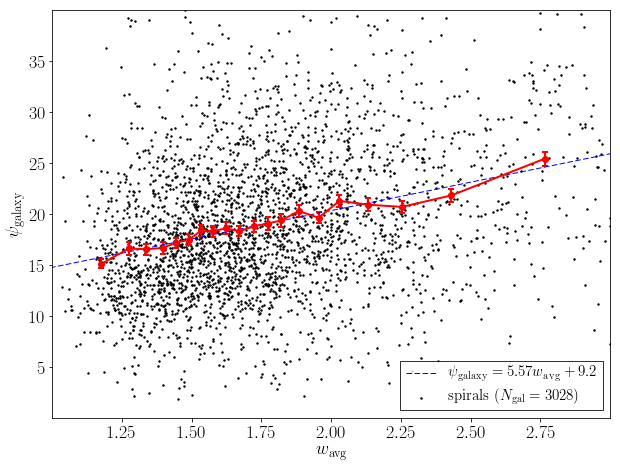

In [25]:
from xy_plots import x_vs_y
from scipy.optimize import curve_fit
from contours import kde_contour

def linear(x,m,c):
    return m*x + c

fig = plt.figure(figsize=(10,7.5))
ax = plt.subplot(111)

#####################
x_i = gz2_stats['w_wtd_avg'][sample_ok]
y = sparcfire_matched['P_wtd_avg'][sample_ok]
#_ = kde_contour(x,y,fill=True,zorder=1)

xy = x_vs_y(x_i,y)
xy = xy.continuous_vs_continuous_binned(equal_N=True,bins=20)
_ = xy.error_plot(ax,style='bar',color='r',lw=2,
                  capsize=3,capthick=2,marker='o')
_ = xy.scatter(ax,color='k',s=2,zorder=0,
               label='spirals ($N_\mathrm{{gal}}={}$)'.format(len(x)))

p_fit, pcov = curve_fit(linear,x_i,y)

x_guide = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],1000)
_ = plt.plot(x_guide,linear(x_guide,*p_fit),color='b',lw=1,linestyle='dashed',
             label='$\psi_\mathrm{{galaxy}}={}w_\mathrm{{avg}}+{}$'.format(*np.round(p_fit,decimals=2)))

_ = ax.legend(fancybox=False,edgecolor='k',fontsize=15)
_ = ax.set_xlabel('$w_\mathrm{avg}$')
_ = ax.set_ylabel('$\psi_\mathrm{galaxy}$')
_ = ax.set_xlim(1,3)
_ = ax.set_ylim(0,40)

#####################

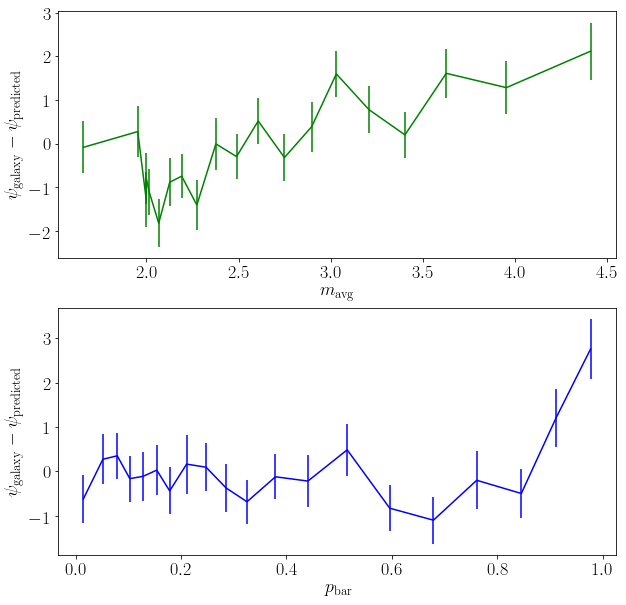

In [27]:
# Now attempt to measure the error:

deviation = y - linear(x_i,*p_fit)

fig, axarr = plt.subplots(2,1,figsize=(10,10))

ax = axarr[0]
x = gz2_stats['m_wtd_avg'][sample_ok]
xy = x_vs_y(x,deviation)
xy = xy.continuous_vs_continuous_binned(bins=20,equal_N=True)
xy.error_plot(ax,style='bar',color='g')
_ = ax.set_xlabel('$m_\mathrm{avg}$')
_ = ax.set_ylabel('$\psi_\mathrm{galaxy} - \psi_\mathrm{predicted}$')


ax = axarr[1]
x = gz2_stats['p_bar'][sample_ok]
xy = x_vs_y(x,deviation)
xy = xy.continuous_vs_continuous_binned(bins=20,equal_N=True)
xy.error_plot(ax,style='bar',color='b')
_ = ax.set_xlabel('$p_\mathrm{bar}$')
_ = ax.set_ylabel('$\psi_\mathrm{galaxy} - \psi_\mathrm{predicted}$')

#### Conclusion here: we see a strong trend that a lot of the scatter in the pitch angle measurement can be attributed to m and p_bar. .'., we can potentially shrink the errors here

In [33]:
x_multi = np.array([gz2_stats['w_wtd_avg'][sample_ok],
                    gz2_stats['m_wtd_avg'][sample_ok],
                    gz2_stats['p_bar'][sample_ok]]).T

y = sparcfire_matched['P_wtd_avg'][sample_ok]

def multilinear3(x,m0,m1,m2,c):
    return m0*x[:,0] + m1*x[:,1] + m2*x[:,2] + c

def multilinear2(x,m0,m1,c):
    return m0*x[:,0] + m1*x[:,1] + c#+ m2*x[:,2] + c

p_multi, p_cov = curve_fit(multilinear3,x_multi,y)

In [41]:
x_multi = np.array([gz2_stats['w_wtd_avg'][sample_ok],
                    gz2_stats['m_wtd_avg'][sample_ok]]).T

y = sparcfire_matched['P_wtd_avg'][sample_ok]

def multilinear3(x,m0,m1,m2,c):
    return m0*x[:,0] + m1*x[:,1] + m2*x[:,2] + c

def multilinear2(x,m0,m1,c):
    return m0*x[:,0] + m1*x[:,1] + c#+ m2*x[:,2] + c

p_multi, p_cov = curve_fit(multilinear2,x_multi,y)

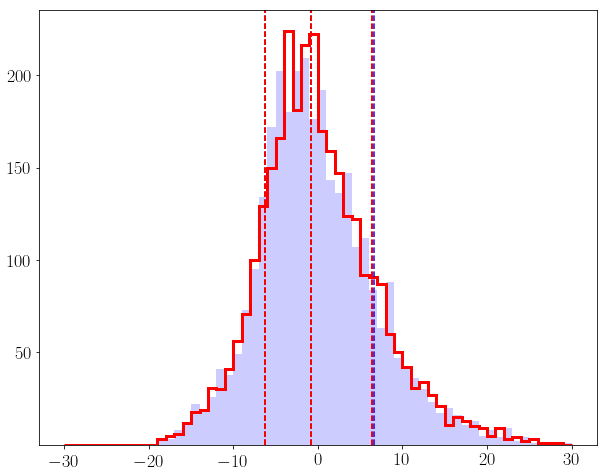

In [42]:
deviation_multi = y - multilinear2(x_multi,*p_multi)

bins = np.linspace(-30,30,61)
_ = plt.hist(deviation,bins,histtype='stepfilled',color='b',alpha=0.2)
_ = plt.hist(deviation_multi,bins,color='r',histtype='step',lw=3)
for percentile in (16,50,84):
    percentile_dev = np.percentile(deviation,percentile)
    percentile_dev_multi = np.percentile(deviation_multi,percentile)
    plt.axvline(percentile_dev,color='b',linestyle='dashed')
    plt.axvline(percentile_dev_multi,color='r',linestyle='dashed',lw=2)

dev_error = (np.percentile(deviation,84) - np.percentile(deviation,16))/2
dev_multi_error = (np.percentile(deviation_multi,84) - 
                   np.percentile(deviation_multi,16))/2

In [51]:
print('psi = {}w_avg + {}m_avg + {}'.format(*np.round(p_multi,decimals=2)))
print(np.std(deviation),np.std(deviation_multi))

psi = 6.37w_avg + 1.3m_avg + 4.34
7.03301007007 6.97494780261


In [62]:
gz2_stats['psi_gz2'] = linear(gz2_stats['w_wtd_avg'],*p_fit)

# add in some fake error:
psi_error = np.random.randn(len(gz2_stats))*np.std(deviation_multi)
gz2_stats['psi_gz2+error'] = gz2_stats['psi_gz2'] + psi_error
gz2_stats['psi_gz2+error'][gz2_stats['psi_gz2+error']<0] = 0

gz2_stats.write('fits/gz2_statistics.fits',overwrite=True)

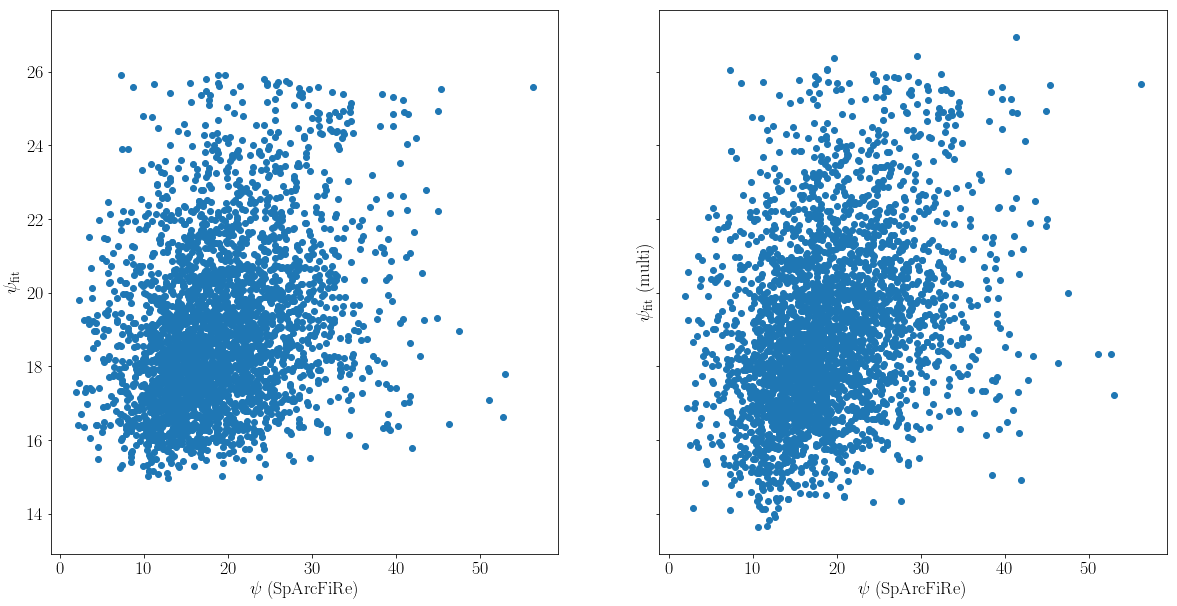

In [53]:
fig, axarr = plt.subplots(1,2,figsize=(20,10),sharex=True,sharey=True) 

_ = axarr[0].set_xlabel('$\psi$ (SpArcFiRe)')
_ = axarr[1].set_xlabel('$\psi$ (SpArcFiRe)')
_ = axarr[0].set_ylabel('$\psi_\mathrm{fit}$')
_ = axarr[1].set_ylabel('$\psi_\mathrm{fit}$ (multi)')
#_ = axarr[0].plot([0,40],[0,40],'k-')
#_ = axarr[1].plot([0,40],[0,40],'k-')

axarr[0].scatter(y,linear(x_i,*p_fit))
axarr[1].scatter(y,multilinear2(x_multi,*p_multi))

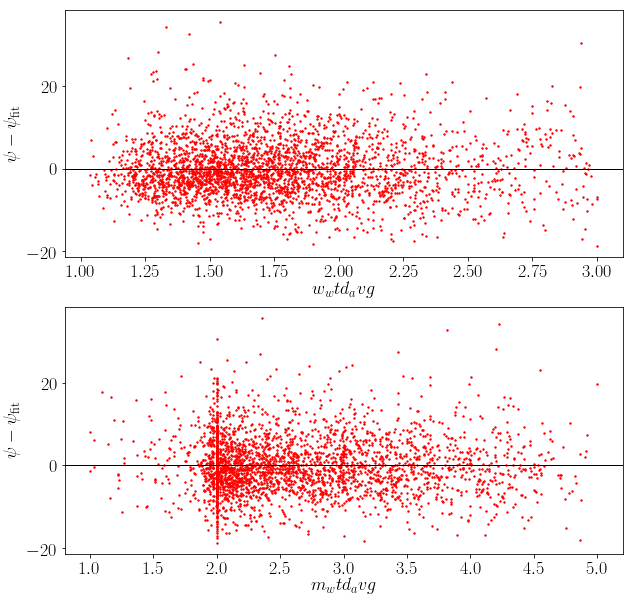

In [59]:
fig, axarr = plt.subplots(2,1,figsize=(10,10))

_ = axarr[0].set_xlabel('$w_wtd_avg$')
_ = axarr[1].set_xlabel('$m_wtd_avg$')
_ = axarr[0].set_ylabel('$\psi-\psi_\mathrm{fit}$')
_ = axarr[1].set_ylabel('$\psi-\psi_\mathrm{fit}$')

for ax, x in zip(axarr,[x_multi[:,0],x_multi[:,1]]):
    plt.sca(ax)
    plt.axhline(0,color='k',lw=1)
    plt.scatter(x,deviation_multi,color='r',s=2)